## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [6]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
class args:
    filename = "net12062020.gml"
    scale = 40
    figsize = 5,5

In [9]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [10]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()
    
def DrawSolFlow (G,x,f):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos,  
                           node_shape='o', 
                           node_size=600,
                           node_color='r', 
                           label=[G.nodes()])
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           nodelist = [root], 
                           node_shape='o',
                           node_size=600,
                           node_color='k', 
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    
    for h,k in G.edges():
        
        flow = abs(f[h,k].x - f[k,h].x)
        
        G[h][k]['capacity'] = x[h,k].x
        if x[h,k].x > 0.00001:
            if x[h,k].x > 0.999999:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='k')
                
                nx.draw_networkx_edge_labels(G, 
                                             pos=pos,
                                             edge_labels={(h,k):'{:.2f}'.format(flow)})
            else:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='r')

    plt.axis('off')
    plt.show()

In [11]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 20 nodes and 190 edges


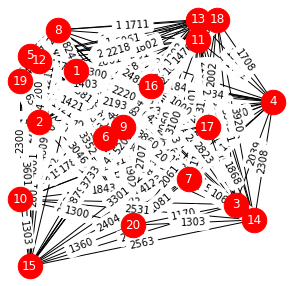

In [12]:
DrawInitG(G, withedges=True)

## Multi commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 


$$
y_{ij}= \{\text{capacity for the flow of each commodity $k$ in arc } (i,j)\}
$$

$$
f^k_{ij} = \{\text{flow of commodity $k$ carried by the arc } (i,j)\}
$$


\begin{alignat}{3}
\min cx &&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \; \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

In [18]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [19]:
G.nodes(data=True)

NodeDataView({0: {'y': 39, 'x': 9, 'old': 0}, 1: {'y': 29, 'x': 5, 'old': 1}, 2: {'y': 13, 'x': 26, 'old': 2}, 3: {'y': 33, 'x': 30, 'old': 3}, 4: {'y': 42, 'x': 4, 'old': 4}, 5: {'y': 26, 'x': 12, 'old': 5}, 6: {'y': 18, 'x': 21, 'old': 6}, 7: {'y': 47, 'x': 7, 'old': 7}, 8: {'y': 28, 'x': 14, 'old': 8}, 9: {'y': 14, 'x': 3, 'old': 9}, 10: {'y': 45, 'x': 22, 'old': 10}, 11: {'y': 41, 'x': 5, 'old': 11}, 12: {'y': 49, 'x': 22, 'old': 12}, 13: {'y': 10, 'x': 28, 'old': 13}, 14: {'y': 1, 'x': 4, 'old': 14}, 15: {'y': 36, 'x': 17, 'old': 15}, 16: {'y': 28, 'x': 23, 'old': 16}, 17: {'y': 49, 'x': 24, 'old': 17}, 18: {'y': 37, 'x': 3, 'old': 18}, 19: {'y': 9, 'x': 15, 'old': 19}})

In [29]:
# Define the root node
root = 0

# Define a Directed Graph by doubling the edges of G
D = G.to_directed()

mstmulti = gb.Model()

x = mstmulti.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],
                    ub = 1.0,
                    vtype=gb.GRB.BINARY,
                    name='x')

y = mstmulti.addVars(D.edges(), 
                         ub=1.0, vtype=gb.GRB.BINARY,
                         name='y')

commodities = list(G.nodes())[1:]
f = mstmulti.addVars(D.edges(), 
                         commodities, 
                         ub=G.number_of_nodes(), 
                         vtype=gb.GRB.CONTINUOUS, 
                         name='f')

# ROOT CONSTRAINTS: there is one constraint for each commodity
# for k in commodities:
#     name = "Root_Com_"+str(k)
mstmulti.addConstrs((f.sum(root, '*', k) - f.sum('*',root,k) == 1 
                     for k in commodities), 
                    name="root_com")
    
    
# BALANCE CONSTRAINTS: written for all nodes different from root
for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            
            
# TERMINAL CONSTRAINTS: there is one constraint for each commodity
for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)
    
    
# VARIABLE CAPACITY constraints
for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)
        
    
# CARDINALITY constraint
mstmulti.addConstr(y.sum() == G.number_of_nodes() - 1, "Cardinality")


# EQUALITY constraints
for i,j in G.edges():
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    

mstmulti.update()
mstmulti.write('multi.lp')

In [30]:
# Net 2 constraints
mstmulti.addConstrs((x.sum(j,'*') <= 2 for j in G.nodes() if j != root and (j % 2) != 0), name='odd_deg')
mstmulti.addConstrs((x.sum(j,'*') <= 3 for j in G.nodes() if j != root and (j % 2) == 0), name='even_deg')

mstmulti.update()

In [31]:
mstmulti.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7810 rows, 7790 columns and 30001 nonzeros
Model fingerprint: 0x0bd53a29
Variable types: 7220 continuous, 570 integer (570 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 6e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 31508.000000
Presolve removed 4 rows and 25 columns
Presolve time: 0.02s
Presolved: 7806 rows, 7765 columns, 29970 nonzeros
Variable types: 7220 continuous, 545 integer (545 binary)

Root relaxation: objective 1.187000e+04, 1778 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    11870.000000 11870.0000  0.00%     -    0s

Explored 0 nodes (1778 simplex ite

Optimal solution: 11870.0


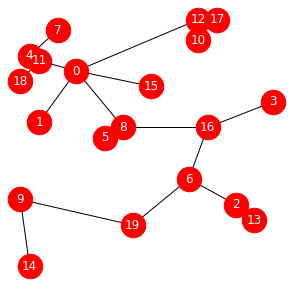

In [32]:
print ("Optimal solution:", mstmulti.objVal)
DrawSol(G,x)